# PDF text extraction tool
Author: Roald Teunissen

## Libraries

In [1]:
import os
import pandas as pd
import numpy as np

# Scikit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

# Word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Properties

In [2]:
data_dir = os.path.join(os.getcwd(), '../../data/')

# PAPERS_DIR = os.path.join(data_dir, 'external/papers')
# PAPERS_DATA_DIR__RAW = os.path.join(data_dir, 'raw', 'papers_raw.csv')
PAPERS_DATA_DIR__PROCESSED = os.path.join(data_dir, 'processed', 'papers_processed.csv')

# Load data

In [3]:
papers = pd.read_csv(PAPERS_DATA_DIR__PROCESSED)

In [4]:
df_train, df_test = train_test_split(papers, test_size=0.2, shuffle=True)

# Exploratory data analysis

chemistry                        26
life sciences and biomedicine    26
Name: topic, dtype: int64


<AxesSubplot: ylabel='topic'>

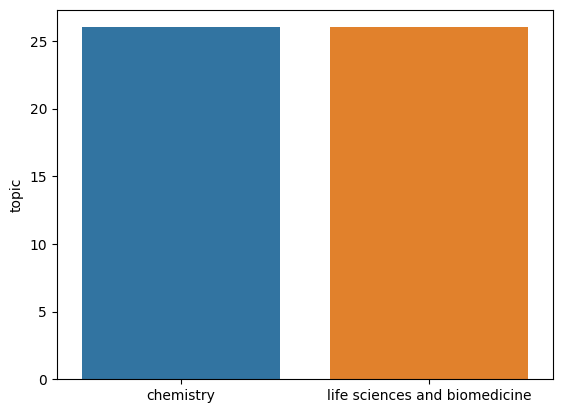

In [5]:
topic_index = df_train['topic'].unique()
value_counts = df_train['topic'].value_counts().reindex(index = topic_index)

print(value_counts)
sns.barplot(
    x = topic_index, 
    y = value_counts
)

In [6]:
# Check missing values
df_train.isna().sum()

title      0
topic      0
content    0
dtype: int64

In [7]:
print('Word count')
df_train['word_count'] = df_train['content'].apply(lambda x: len(str(x).split()))
print('chemistry', df_train[df_train['topic']=='chemistry']['word_count'].mean()) # chemistry
print('life sciences and biomedicine', df_train[df_train['topic']=='life sciences and biomedicine']['word_count'].mean()) # life sciences and biomedicine
print('\n')

print('Character count')
df_train['char_count'] = df_train['content'].apply(lambda x: len(str(x)))
print('chemistry', df_train[df_train['topic']=='chemistry']['char_count'].mean()) # chemistry
print('life sciences and biomedicine', df_train[df_train['topic']=='life sciences and biomedicine']['char_count'].mean()) # life sciences and biomedicine
print('\n')

print('Unique word count')
df_train['unique_word_count'] = df_train['content'].apply(lambda x: len(set(str(x).split())))
print('chemistry',df_train[df_train['topic']=='chemistry']['unique_word_count'].mean()) # chemistry
print('life sciences and biomedicine', df_train[df_train['topic']=='life sciences and biomedicine']['unique_word_count'].mean()) # life sciences and biomedicine

Word count
chemistry 1678.076923076923
life sciences and biomedicine 2338.846153846154


Character count
chemistry 11533.461538461539
life sciences and biomedicine 17162.19230769231


Unique word count
chemistry 626.8461538461538
life sciences and biomedicine 887.8461538461538


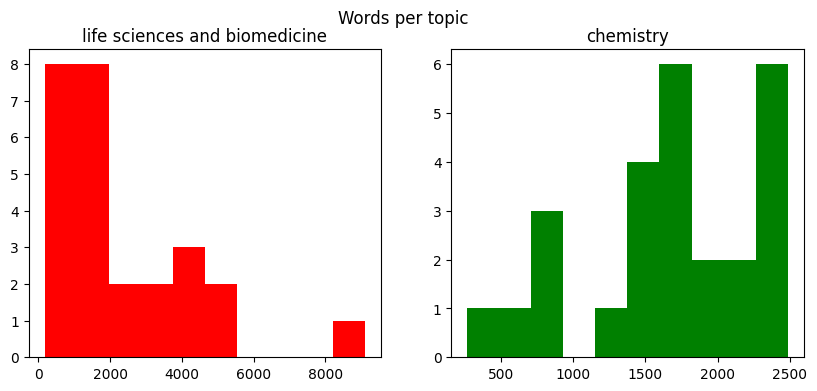

In [8]:
# Plotting word count
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

train_words = df_train[df_train['topic']=='life sciences and biomedicine']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('life sciences and biomedicine')

train_words=df_train[df_train['topic']=='chemistry']['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('chemistry')

fig.suptitle('Words per topic')
plt.show()

# Models

### Word2Vec model

In [9]:
df_train['clean_text_tok'] = [nltk.word_tokenize(i) for i in df_train['content']] # Tokenize content

# Create model
# min_count = 1 means word should be present at least across all documents
model = Word2Vec(df_train['clean_text_tok'], min_count = 1)

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  # Combine word and its vector

# For converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

### Train test split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df_train["content"],
                                                  df_train["topic"],
                                                  test_size = 0.2,
                                                  shuffle = True)
# Convert value
y_val = y_val.to_numpy()

# Tokenize for word2vec
X_train_tok = [nltk.word_tokenize(i) for i in X_train]
X_val_tok = [nltk.word_tokenize(i) for i in X_val]

### TF-IDF preperation

In short:<br>
_Short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus._

In [11]:
# Initialize vectorizer to prepare our data for our model
tfidf_vectorizer = TfidfVectorizer(use_idf = True)

# Vectorize train and validation data
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

Notice that we only fit the training data with our vectorizer's `fit_transform()` function.<br>
This will set the word-indexes and weights to match the training data.

### Word2vec preperation

In short: <br>
_As the name implies, **word2vec** represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that they capture the semantic and syntactic qualities of words; as such, a simple mathematical function (cosine similarity) can indicate the level of semantic similarity between the words represented by those vectors._

In [12]:
# Initialize word embedding model
modelw = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

## Building ML models for text classification

In [13]:
encoder = OrdinalEncoder() 

In [14]:
def plot_confusion_matrix(y_val, y_pred):
        print('Total amount of datapoints: {}'.format(len(y_val)))

        cf_matrix = confusion_matrix(y_val, y_pred)

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [15]:
# Reiterate what our unique values are
[[unique_val] for unique_val in df_train["topic"].unique()]

[['chemistry'], ['life sciences and biomedicine']]

### Logistic Regression (TF-IDF)

In [16]:
# Define and fit model
lr_tfidf = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

# Make a prediction on the validation data
y_predict = lr_tfidf.predict(X_val_vectors_tfidf) 
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1] 

# Encode from topics [a,b,c,d] to numbers [1., 2., 3., 4.]
y_predict = encoder.fit_transform(y_predict.reshape(-1,1))
y_val = encoder.fit_transform(y_val.reshape(-1,1))

Analyse the performance our model

In [17]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



Total amount of datapoints: 11


<AxesSubplot: >

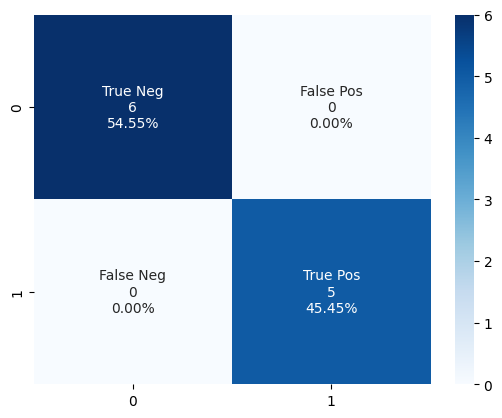

In [18]:
plot_confusion_matrix(y_val, y_predict)

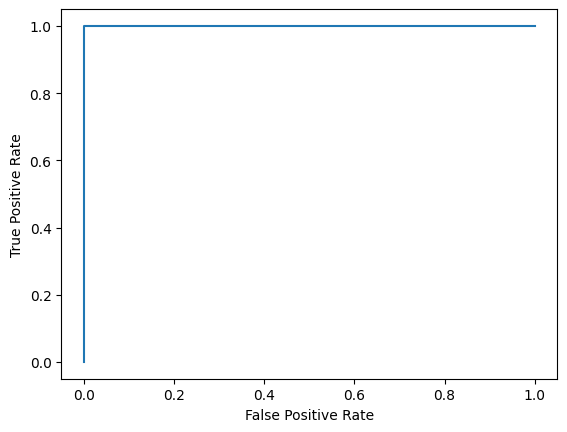

In [19]:
fpr, tpr, thresholds = roc_curve(y_val, y_prob)

# Create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Naive Bayes (tf-idf)

In [20]:
# Define and fit model
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)

# Make a prediction on the validation data
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]

# Encode from topics [a,b,c,d] to numbers [1., 2., 3., 4.]
y_predict = encoder.fit_transform(y_predict.reshape(-1,1))
y_val = encoder.fit_transform(y_val.reshape(-1,1))

Analyse the performance our model

In [21]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



Total amount of datapoints: 11


<AxesSubplot: >

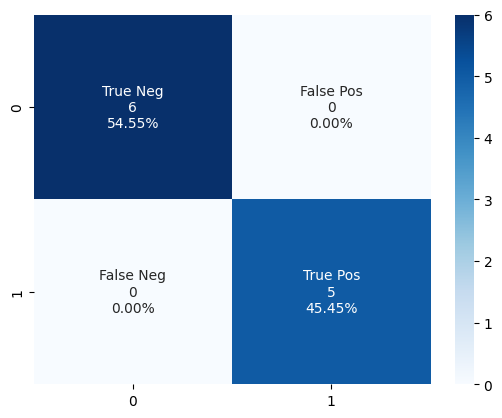

In [22]:
plot_confusion_matrix(y_val, y_predict)

### Logistic Regression (w2v)

In [23]:
# Define and fit model
lr_w2v = LogisticRegression(solver = 'liblinear', C = 10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

# Make a prediction on the validation data
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]

# Encode from topics [a,b,c,d] to numbers [1., 2., 3., 4.]
y_predict = encoder.fit_transform(y_predict.reshape(-1,1))
y_val = encoder.fit_transform(y_val.reshape(-1,1))

Analyse the performance our model

In [24]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         6
         1.0       0.71      1.00      0.83         5

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



Total amount of datapoints: 11


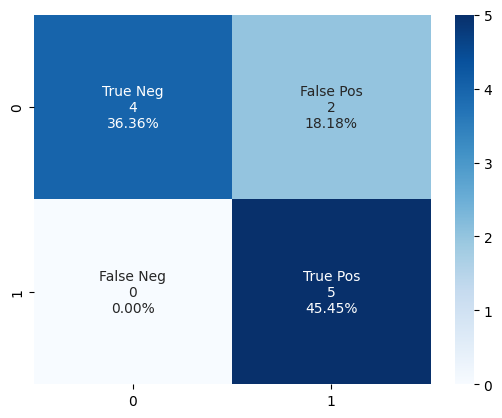

In [25]:
lr_w2v_heatmap = plot_confusion_matrix(y_val, y_predict)

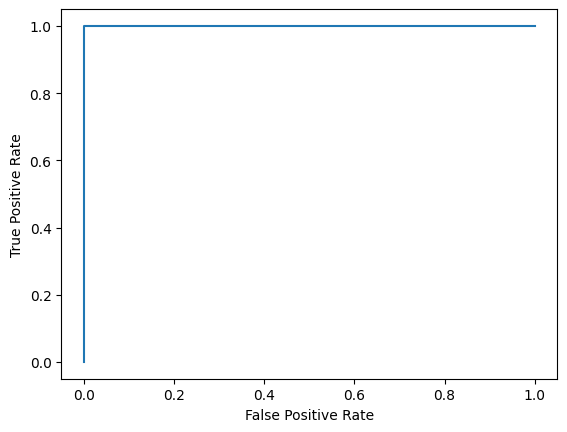

In [26]:
# Create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Testing on unlabelled data

In [27]:
# Converting X_test to vector
X_test = df_test['content'] 
X_test_vec = tfidf_vectorizer.transform(X_test)
X_test_vec_w2v = modelw.transform(X_test)

#### Choose a model:
Run one of the cells to make a prediction with a specific model

Total amount of datapoints: 14


<AxesSubplot: >

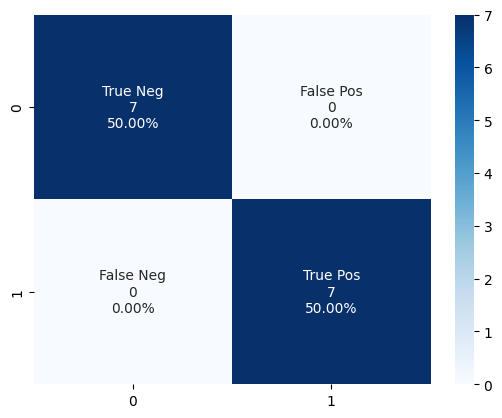

In [28]:
# Logistic Regression TF-IDF
df_test['predicted_topic'] = lr_tfidf.predict(X_test_vec)
df_test['predict_prob'] = lr_tfidf.predict_proba(X_test_vec)[:,1]

plot_confusion_matrix(df_test['topic'], df_test['predicted_topic'])

Total amount of datapoints: 14


<AxesSubplot: >

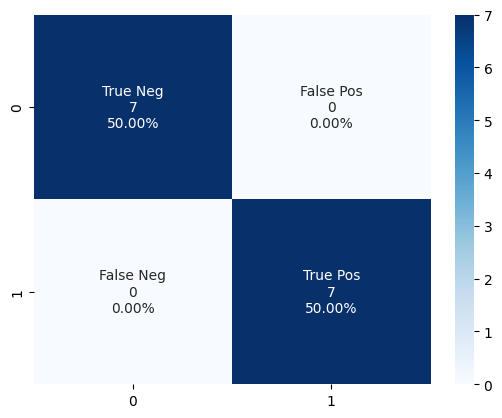

In [29]:
# Naive Bayes TF-IDF
df_test['predicted_topic'] = nb_tfidf.predict(X_test_vec)
df_test['predict_prob'] = nb_tfidf.predict_proba(X_test_vec)[:,1]

plot_confusion_matrix(df_test['topic'], df_test['predicted_topic'])

Total amount of datapoints: 14


<AxesSubplot: >

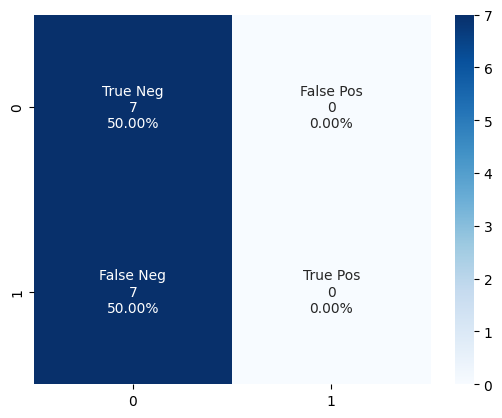

In [30]:
# Logistic Regression word2vec
df_test['predicted_topic'] = lr_w2v.predict(X_test_vec_w2v)
df_test['predict_prob'] = lr_w2v.predict_proba(X_test_vec_w2v)[:,1]

plot_confusion_matrix(df_test['topic'], df_test['predicted_topic'])

In [31]:
df_test.head(30)

,title,topic,content,predicted_topic,predict_prob
7,Electrochromic and optical study of sol-gel Ti...,chemistry,journal physic conference series paper open ac...,chemistry,0.020797
49,Machine Learning Tool A Novel Complementary Me...,life sciences and biomedicine,psychiatria danubina vol pp letter editor medi...,chemistry,0.025328
39,Dynamic Cardiac MRI Reconstruction Using Combi...,life sciences and biomedicine,isbi nuclear norm regularization ieee th inter...,chemistry,0.018566
10,Green synthesis of Co3O4 nanoparticles using E...,chemistry,content work may use term creative common attr...,chemistry,0.022780
53,Mothers' Anxiety to Aggravated Acute Fear of E...,life sciences and biomedicine,psychiatria danubina vol pp http doi org psyd ...,chemistry,0.021461
48,Learning to segment prostate cancer by aggress...,life sciences and biomedicine,learn segment prostate cancer aggressiveness s...,chemistry,0.022645
16,Influence of TiO2 addition on the magnetic pro...,chemistry,content work may use term creative common attr...,chemistry,0.021727
29,Ultrafast carrier generation in Bi1-xSbx thin ...,chemistry,ultrafast carrier generation bi xsbx thin film...,chemistry,0.013992
25,Synthesis of ZnOrGOTiO2 Composite and Its Phot...,chemistry,content work may use term creative common attr...,chemistry,0.022546
38,Differentiable Projection from Optical Coheren...,life sciences and biomedicine,differentiable projection optical coherence to...,chemistry,0.019986
